In [3]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

from igraph import * 
from scipy import *
# import scipy.imageio.imread
# from scipy.imageio import imread
import maxflow
from maxflow import *
from IPython import display 
import warnings
warnings.filterwarnings("ignore")

In [4]:
def read_img(path,a=3):
    
    if a==3:
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if a==1:
        image = cv2.imread(path, 0)
    return image

def show_img(img,text='',a=3):
    
#     img = cv2.cvtColor(img, cv2.BGR2RGB)
    if a==3:
        plt.imshow(img)
    elif a==1:
        plt.imshow(img,cmap='gray')
    plt.axis("off")
    plt.title(text)
    plt.show()
    return 


def plot_result(img,alpha,it):
    
    img2 = np.copy(img)   ;  img3 = np.copy(img)
    img2[alpha==0]  = [0,0,0] ;  img3[alpha!=0]  = [0,0,0]

    fig = plt.figure(figsize=(12,4))
#     fig = plt.figure()
    ax = fig.add_subplot(1,2,1)
    ax.imshow(img2)
    ax.axis('off')
    ax.set_title('Foreground Mask')

    ax = fig.add_subplot(1,2,2)
    ax.imshow(img3)
    ax.axis('off')
    ax.set_title('Background Mask')
    
#     plt.suptitle("Iteration "+str(it))
    plt.show()

    return 


def plot_figure(img_arr,a,b,text='',c=3):
    fig = plt.figure(figsize=(b*5,a*5+1))
    for i in range(1,a+1):
        for j in range(1,b+1):
            ax=fig.add_subplot(a,b,(i-1)*b+j)
            if c==3:
                ax.imshow(img_arr[(i-1)*b+j-1])
            if c==1:
                ax.imshow(img_arr[(i-1)*b+j-1],cmap='gray')
            ax.axis("off")
            ax.set_title(title_arr[(i-1)*b+j-1], fontsize=12)
            
            ax.set_title("image - "+str((i-1)*b+j)+" size "+str(img_arr[(i-1)*b+j-1].shape), fontsize=12)
    
    plt.suptitle(text, fontsize=15)
    #plt.tight_layout()
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0,rect=[0, 0, 1, 0.95])
    #fig.tight_layout(rect=[0, 0.01, 1, 0.95])
    plt.show()

    return 


In [5]:
def output(img,mask):
    img2 = np.copy(img)
    img2[mask==0]  = [0,0,0]
    return img2

In [6]:
def TCs(shape,mask):

    x,y,_ = shape
    x,y = np.meshgrid(range(x),range(y))
    x = x.T ; y=y.T
    
    TB = np.vstack((x[mask==0].flatten(),y[mask==0].flatten()))
    TU = np.vstack((x[mask==1].flatten(),y[mask==1].flatten()))
    TF = np.vstack((x[mask==2].flatten(),y[mask==2].flatten()))
    TA = np.vstack((x[mask>=0].flatten(),y[mask>=0].flatten()))
    
    return TB, TU, TF, TA
    
    

In [7]:
def GMM(img, n, alpha, TB, TU, TF, l):
    
    gm = GaussianMixture(n_components=5, random_state=0).fit(img[alpha==l])
    covariance = gm.covariances_
    μ = gm.means_
    
    
    p = gm.predict(img.reshape(-1,3))
    pv,c = np.unique(p, return_counts=True)
    
    
    log_weight = -np.log(c/np.sum(c))
    log_covariance = np.log(np.linalg.det(covariance))/2
    inv_covariance = np.linalg.inv(covariance)
    
    
    p_covariance_p = np.zeros(alpha.shape)
    p = p.reshape(img.shape[:2])
    for i in range(len(pv)):
        p_covariance_p[p==i] = np.sum(((img[p==i] - μ[i])@inv_covariance[i])*(img[p==i] - μ[i]),axis=1)

    
    D = np.zeros(alpha.shape)
    D[TF[0],TF[1]] = 1e100*(1-l) ; D[TB[0],TB[1]] = 1e100*(l)
    D[TU[0],TU[1]] = log_weight[p[TU[0],TU[1]]] + log_covariance[p[TU[0],TU[1]]] + p_covariance_p[TU[0],TU[1]]

    return D

In [8]:
def neighbours(img,gamma = 50):
    
    l,b,_ = img.shape

    tx1,ty1 = np.meshgrid(range(l),range(b-1)) # for neighbours with horizontal edges
    tx2,ty2 = np.meshgrid(range(l-1),range(b)) # for neighbours with vertical edges

    tx1 = tx1.flatten()
    ty1 = ty1.flatten()
    x1 = tx1 ; y1 = ty1
    x2 = tx1 ; y2 = ty1+1

    tx2 = tx2.flatten()
    ty2 = ty2.flatten()
    x1 = np.append(x1,tx2)   ; y1 = np.append(y1,ty2)
    x2 = np.append(x2,tx2+1) ; y2 = np.append(y2,ty2)

    X1 = x1*b+y1+1
    X2 = x2*b+y2+1
    
    dist = np.linalg.norm(img[x1,y1].astype('float')-img[x2,y2].astype('float'),axis=1)
    dist = gamma*np.e**(-dist/2/np.mean(dist))
        
    return X1,X2,dist


In [9]:
def grab_cut(img,mask,alpha, n ,it):

    l,b,_ = img.shape
    g = Graph() ; g.add_vertices(l*b+2)
    
    TB, TU, TF, TA = TCs(img.shape, mask)
    X1,X2,V = neighbours(img)
    D = TA[0]*b+TA[1]+1
    
    fg = int(0) ; bg = int(l*b+1)
    v1 = np.concatenate((D*0, bg*((D*0)+1),X1))
    v2 = np.concatenate((D  ,      D      ,X2))
    edge_list = list(map(tuple, np.vstack((v1,v2)).T))
    g.add_edges(edge_list)

    
    # every iteration includes these steps
    for i in range(it):
        
        D1 = GMM(img, n, alpha, TB, TU, TF, l=0)
        D0 = GMM(img, n, alpha, TB, TU, TF, l=1)
    
        weight_list = list(np.concatenate((D1.flatten(),D0.flatten(),V)))
        g.es['weight'] = weight_list

        c = g.st_mincut(int(0),int(l*b+1),'weight')
        
        c0 = c[0] ; c0.remove(fg) ; c0 = np.array(c0)
        c1 = c[1] ; c1.remove(bg) ; c1 = np.array(c1)


        alpha[(c0-1)//b , (c0-1)%b] = 1 # new foreground pixels
        alpha[(c1-1)//b , (c1-1)%b] = 0 # new background pixels 
    
        print("Foreground Mask = ",len(c[0]))
        print("Background Mask = ",len(c[1]))
        plot_result(img,alpha,i+1)

# Some other break condition like minimization of energy can be used here
#         if break_condition:
#             break        
        
    return alpha
    
    

In [10]:
class EventHandler:
    """
    Class for handling user input during segmentation iterations 
    """
    
    def __init__(self, flags, img, _mask, colors):
        
        self.FLAGS = flags
        self.ix = -1
        self.iy = -1
        self.img = img
        self.img2 = self.img.copy()
        self._mask = _mask
        self.COLORS = colors

    @property
    def image(self):
        return self.img
    
    @image.setter
    def image(self, img):
        self.img = img
        
    @property
    def mask(self):
        return self._mask
    
    @mask.setter
    def mask(self, _mask):
        self._mask = _mask
    
    @property
    def flags(self):
        return self.FLAGS 
    
    @flags.setter
    def flags(self, flags):
        self.FLAGS = flags
    
    def handler(self, event, x, y, flags, param):

        # Draw the rectangle first
        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                self.FLAGS['DRAW_RECT'] = True
                self.ix, self.iy = x,y

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_RECT'] == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), self.COLORS['BLUE'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(self.ix - x), abs(self.iy - y))
                self.FLAGS['rect_or_mask'] = 0

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['rect_over'] == False:
                self.FLAGS['DRAW_RECT'] = False
                self.FLAGS['rect_over'] = True
                cv2.rectangle(self._mask, (self.ix, self.iy), (x, y), self.COLORS['RED'], 2)
                self.FLAGS['RECT'] = (min(self.ix, x), min(self.iy, y), abs(x), abs(y))
                self.FLAGS['rect_or_mask'] = 0

        
        # Draw strokes for refinement 

        if event == cv2.EVENT_LBUTTONDOWN:
            if self.FLAGS['rect_over'] == False:
                print('Draw the rectangle first.')
            else:
                self.FLAGS['DRAW_STROKE'] = True
                cv2.circle(self.img, (x,y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x,y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_MOUSEMOVE:
            if self.FLAGS['DRAW_STROKE'] == True:
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

        elif event == cv2.EVENT_LBUTTONUP:
            if self.FLAGS['DRAW_STROKE'] == True:
                self.FLAGS['DRAW_STROKE'] = False
                cv2.circle(self.img, (x, y), 3, self.FLAGS['value']['color'], -1)
                cv2.circle(self._mask, (x, y), 3, self.FLAGS['value']['val'], -1)

In [11]:
def run(filename: str, n = 5, it = 1):
    """
    Main loop that implements GrabCut. 
    
    Input
    -----
    filename (str) : Path to image
    """
    
    COLORS = {
    'BLACK' : [0,0,0],
    'RED'   : [0, 0, 255],
    'GREEN' : [0, 255, 0],
    'BLUE'  : [255, 0, 0],
    'WHITE' : [255,255,255]
    }

    DRAW_BG = {'color' : COLORS['BLACK'], 'val' : 5}
    DRAW_FG = {'color' : COLORS['WHITE'], 'val' : 3}

    FLAGS = {
        'RECT' : (0, 0, 1, 1),
        'DRAW_STROKE': False,         # flag for drawing strokes
        'DRAW_RECT' : False,          # flag for drawing rectangle
        'rect_over' : False,          # flag to check if rectangle is  drawn
        'rect_or_mask' : -1,          # flag for selecting rectangle or stroke mode
        'value' : DRAW_FG,            # drawing strokes initialized to mark foreground
    }
#     img = read_img(filename)
    img = cv2.imread(filename, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img2 = img.copy()
    mask = np.zeros(img.shape[:2], dtype = np.uint8) # mask is a binary array with : 0 - background pixels
                                                     #                               1 - foreground pixels 
    output = np.zeros(img.shape, np.uint8)           # output image to be shown

    # Input and segmentation windows
    cv2.namedWindow('Input Image')
    cv2.namedWindow('Segmented output')
    
    EventObj = EventHandler(FLAGS, img, mask, COLORS)
    cv2.setMouseCallback('Input Image', EventObj.handler)
    cv2.moveWindow('Input Image', img.shape[1] + 10, 90)
    img_list = []
    mask_list = []
    
    
    while(1):
        
        img = EventObj.image
        mask = EventObj.mask
        FLAGS = EventObj.flags
        cv2.imshow('Segmented image', output)
        cv2.imshow('Input Image', img)
        
        k = cv2.waitKey(1)

        # key bindings
        if k == 27:
            # esc to exit
            break
        
        elif k == ord('0'): 
            # Strokes for background
            FLAGS['value'] = DRAW_BG
        
        elif k == ord('1'):
            # FG drawing
            FLAGS['value'] = DRAW_FG
        
        elif k == ord('r'):
            # reset everything
            FLAGS['RECT'] = (0, 0, 1, 1)
            FLAGS['DRAW_STROKE'] = False
            FLAGS['DRAW_RECT'] = False
            FLAGS['rect_or_mask'] = -1
            FLAGS['rect_over'] = False
            FLAGS['value'] = DRAW_FG
            img = img2.copy()
            mask = np.zeros(img.shape[:2], dtype = np.uint8) 
            EventObj.image = img
            EventObj.mask = mask
            output = np.zeros(img.shape, np.uint8)
        
        elif k == 13: 
            rect_ = FLAGS['RECT']
            pakka_fg = np.where((mask==3))
            pakka_bg = np.where((mask==5))
            maybe_fg = np.where((mask==1))
            mask[rect_[1]:rect_[3],rect_[0]:rect_[2]] = 1
            mask[pakka_fg] = 2
            mask[pakka_bg] = 0
            mask[maybe_fg] = 1
            alpha = (mask>0).astype('int')
            alpha = grab_cut(img2,mask,alpha, n, it)
            
            return
        
        EventObj.flags = FLAGS
        mask2 = np.where((mask == 1), 255, 0).astype('uint8')
        output = cv2.bitwise_and(img2, img2, mask = mask2)

Draw the rectangle first.
Foreground Mask =  14136
Background Mask =  140566


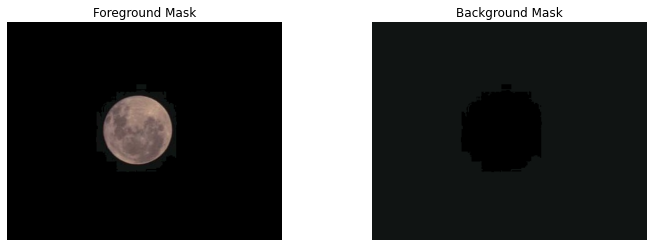

'\nConvergence in one iteration\n'

In [20]:
filename = '../images/fullmoon.jpg'              
run(filename)
cv2.destroyAllWindows()

'''
Convergence in one iteration
'''

Draw the rectangle first.
Foreground Mask =  89870
Background Mask =  217332


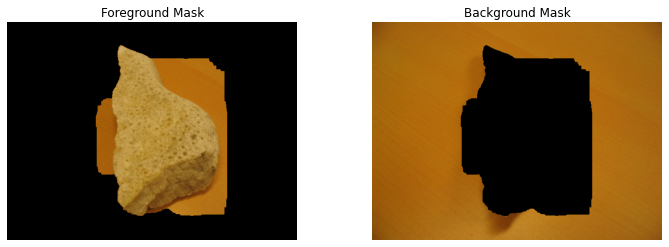

In [15]:
filename = '../images/stone1.jpg'               # Path to image file
run(filename)
cv2.destroyAllWindows()

Draw the rectangle first.
Foreground Mask =  34517
Background Mask =  155808


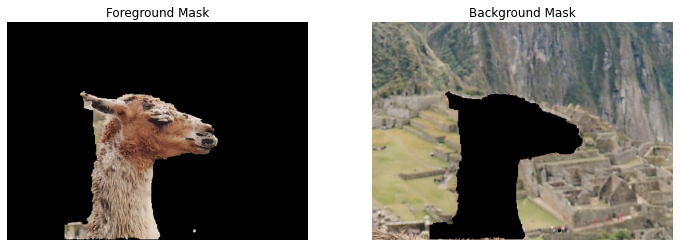

In [13]:
filename = '../images/llama.jpg'               # Path to image file
run(filename, it = 1)
cv2.destroyAllWindows()

Draw the rectangle first.
Foreground Mask =  26521
Background Mask =  86513


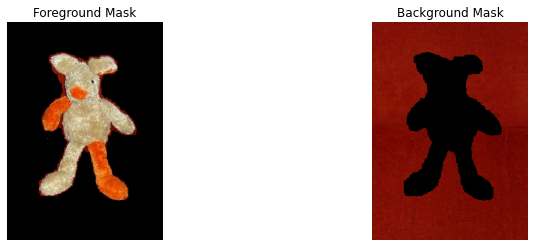

Foreground Mask =  25537
Background Mask =  87497


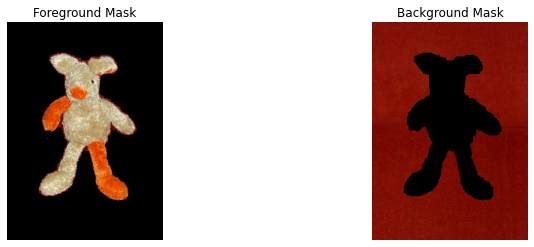

Foreground Mask =  24721
Background Mask =  88313


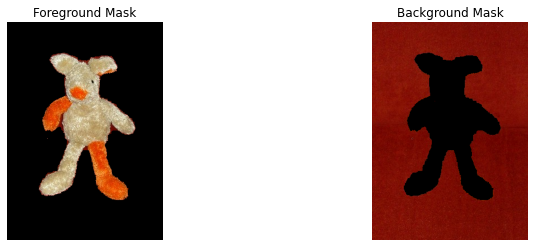

Foreground Mask =  24012
Background Mask =  89022


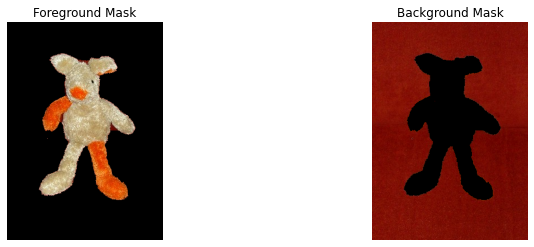

Foreground Mask =  23696
Background Mask =  89338


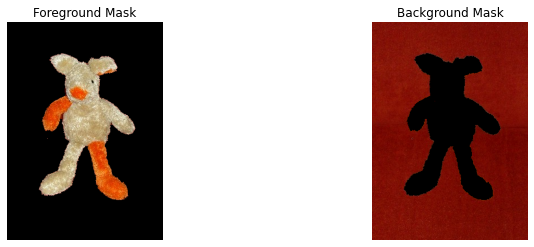

In [22]:
filename = '../images/teddy.jpg'               # Path to image file
run(filename, it = 5)
cv2.destroyAllWindows()

Draw the rectangle first.
Foreground Mask =  21144
Background Mask =  248858


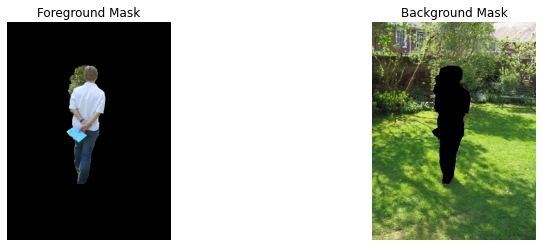

Foreground Mask =  20747
Background Mask =  249255


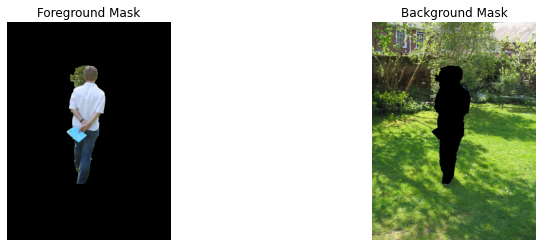

Foreground Mask =  20590
Background Mask =  249412


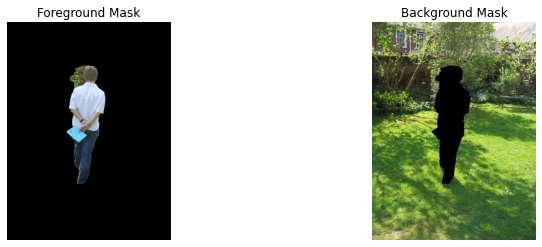

Foreground Mask =  20584
Background Mask =  249418


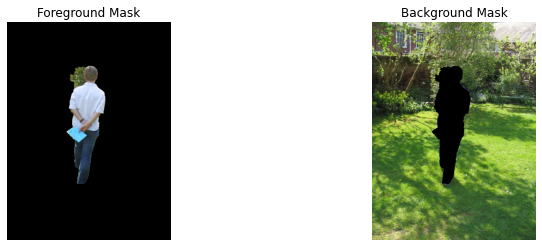

Foreground Mask =  20701
Background Mask =  249301


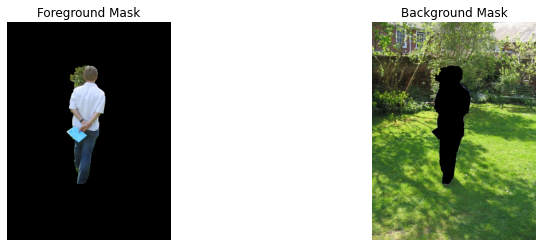

In [45]:
filename = '../images/person7.jpg'               # Path to image file
run(filename, it = 5)
cv2.destroyAllWindows()

## Observations and conclusions

### The tightness of the bounding box

Getting a tight bounding box is crucial. This is because we consider the region outside the bounding box to strictly consist of the background. We then use these background pixels to fit the GMM responsible for the background. This background GMM will also further help us to separate the pixels within the bounding box into foreground and background pixels.

If we don't draw the bounding box tightly, we will lose this crucial information to train the background GMM and thus our segmentation will not be upto the mark.

#### Bounding Box 1

<img  alt="Alt text" src="bounding1_doll.png" width="150" height="150">

#### Output 1
<img  alt="Alt text" src="bounding1_outdoll.png" width="500" height="500">

#### Bounding Box 2
<img  alt="Alt text" src="bounding2_doll.png" width="150" height="150">

#### Output 2
<img  alt="Alt text" src="bounding2_outdoll.png" width="500" height="500">

### The choice of Gamma
As mentioned in the paper, $\gamma$ is the degree of smoothening observed in the segmentation as determined by $\beta$
The paper suggests an optimal value of 50 for $\gamma$. This is also followed in the Boykov and Jolly paper.
It is useful for better seperation between the FG and BG. The higher the gamma, more stricter will be the differentiation.


Below is the segmentation on setting $\gamma$ to 50
<td><img src="gamma_50.png" alt="Drawing" style="width: 400px;"/></td>
Below is the segmentation on setting $\gamma$ to 5000
<td><img src="gamma_5000.png" alt="Drawing" style="width: 400px;"/></td>


### The number of iterations taken to converge
The higher the number of iterations the code is run for, the better the convergence. The convergence criteria that we use is the mincut value. If it doesn't decrease by a given threshold, then we perform a graphcut on the modified alpha matt of the image. We see that for the given image, the segementation gets better with the number of iterations. Note that this segementation is performed without any additional user input apart from the bounding box.

When the code is run for 1 iteration: 
<td><img src="iteration1.jpg" alt="Drawing" style="width: 400px;"/></td>
When the code is run for 5 iterations: 
<td><img src="iteration10.jpg" alt="Drawing" style="width: 400px;"/></td>


### The choice of colourspace
The colourspace in which the experiment is performed does not play a role in the segmentation. This is because each colour in the colourspace will have a unique ratio of the three primary colours in the colourspace.

Segmentation in the RGB colourspace:
<td><img src="sheep_rgb.png" alt="Drawing" style="width: 400px;"/></td>
Segmentation in the HSV colourspace:
<td><img src="sheep_hsv.png" alt="Drawing" style="width: 400px;"/></td>

### Increasing the number of Gaussian Mixture Components
Increasing the number of gaussian mixture components in our Gaussian Mixture Model will allow us to capure a wider spectrum of colours in the foreground and in the background. However, you should be wary of the model not being able to fit all specified components to a test-case. This will result in an error. The paper suggests an optimal number of components to be 5. 